# Evaluation of RAG Using Ragas

In the following notebook we'll explore how to evaluate RAG pipelines using a powerful open-source tool called "Ragas". This will give us tools to evaluate component-wise metrics, as well as end-to-end metrics about the performance of our RAG pipelines.

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating a simple RAG pipeline with [LangChain v0.1.0](https://blog.langchain.dev/langchain-v0-1-0/)
  

- 🤝 Breakout Room #2:
  1. Synthetic Dataset Generation for Evaluation using the [Ragas](https://github.com/explodinggradients/ragas)
  2. Evaluating our pipeline with Ragas
  3. Making Adjustments to our RAG Pipeline
  4. Evaluating our Adjusted pipeline against our baseline
  5. Testing OpenAI's Claim

The only way to get started is to get started - so let's grab our dependencies for the day!

## Motivation

A claim, made by OpenAI, is that their `text-embedding-3-small` is better (generally) than their `text-embedding-ada-002` model.

Here's some passages from their [blog](https://openai.com/blog/new-embedding-models-and-api-updates) about the `text-embedding-3` release:

> `text-embedding-3-small` is our new highly efficient embedding model and provides a significant upgrade over its predecessor, the `text-embedding-ada-002` model...

> **Stronger performance.** Comparing `text-embedding-ada-002` to `text-embedding-3-small`, the average score on a commonly used benchmark for multi-language retrieval ([MIRACL](https://github.com/project-miracl/miracl)) has increased from 31.4% to 44.0%, while the average score on a commonly used benchmark for English tasks ([MTEB](https://github.com/embeddings-benchmark/mteb)) has increased from 61.0% to 62.3%.

Well, with a library like Ragas - we can put that claim to the test!

If what they claim is true - we should see an increase on related metrics by using the new embedding model!

# 🤝 Breakout Room #1

## Task 1: Installing Required Libraries

A reminder that one of the [key features](https://blog.langchain.dev/langchain-v0-1-0/) of LangChain v0.1.0 is the compartmentalization of the various LangChain ecosystem packages!

So let's begin grabbing all of our LangChain related packages!

In [3]:
%pip install -U -q langchain langchain-openai langchain_core langchain-community langchainhub openai

Note: you may need to restart the kernel to use updated packages.


We'll also get the "star of the show" today, which is Ragas!

In [4]:
%pip install -qU ragas

Note: you may need to restart the kernel to use updated packages.


As well, instead of the remote hosted solution that we used last week (Pinecone), we'll be leveraging Meta's [FAISS](https://github.com/facebookresearch/faiss) as the backend for our LangChain `VectorStore`.

We'll also install `unstructured` (from [Unstructured-IO](https://github.com/Unstructured-IO/unstructured)) and its dependencies which will allow us to load PDFs using the `UnstructuredPDFLoader` in the `langchain-community` package!

In [5]:
%pip install -qU faiss_cpu pymupdf pandas

Note: you may need to restart the kernel to use updated packages.


## Task 2: Set Environment Variables

Let's set up our OpenAI API key so we can leverage their API later on.

In [6]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("Please provide your OpenAI Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

## Task 3: Creating a Simple RAG Pipeline with LangChain v0.1.0

Building on what we learned last week, we'll be leveraging LangChain v0.1.0 and LCEL to build a simple RAG pipeline that we can baseline with Ragas.

## Building our RAG pipeline

Let's review the basic steps of RAG again:

- Create an Index
- Use retrieval to obtain pieces of context from our Index that are similar to our query
- Use a LLM to generate responses based on the retrieved context

Let's get started by creating our index.

> NOTE: We're going to start leaning on the term "index" to refer to our `VectorStore`, `VectorDatabase`, etc. We can think of "index" as the catch-all term, whereas `VectorStore` and the like relate to the specific technologies used to create, store, and interact with the index.

### Creating an Index

You'll notice that the largest changes (outside of some import changes) are that our old favourite chains are back to being bundled in an easily usable abstraction.

We can still create custom chains using LCEL - but we can also be more confident that our pre-packaged chains are creating using LCEL under the hood.

#### Loading Data

Let's start by loading some data!

> NOTE: You'll notice that we're using a document loader from the community package of LangChain. This is part of the v0.1.0 changes that make the base (`langchain-core`) package remain lightweight while still providing access to some of the more powerful community integrations.

In [7]:
!git clone https://github.com/AI-Maker-Space/DataRepository

fatal: destination path 'DataRepository' already exists and is not an empty directory.


In [8]:
from langchain_community.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader(
    "DataRepository/MuskComplaint.pdf",
)

documents = loader.load()

In [9]:
documents[0].metadata

{'source': 'DataRepository/MuskComplaint.pdf',
 'file_path': 'DataRepository/MuskComplaint.pdf',
 'page': 0,
 'total_pages': 46,
 'format': 'PDF 1.7',
 'title': '',
 'author': '',
 'subject': '',
 'keywords': '',
 'creator': '',
 'producer': '',
 'creationDate': '',
 'modDate': '',
 'trapped': ''}

#### Transforming Data

Now that we've got our single document - let's split it into smaller pieces so we can more effectively leverage it with our retrieval chain!

We'll start with the classic: `RecursiveCharacterTextSplitter`.

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 700,
    chunk_overlap = 50
)

documents = text_splitter.split_documents(documents)

Let's confirm we've split our document.

In [11]:
len(documents)

159

#### Loading OpenAI Embeddings Model

We'll need a process by which we can convert our text into vectors that allow us to compare to our query vector.

Let's use OpenAI's `text-embedding-ada-002` for this task!

In [12]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    model="text-embedding-ada-002"
)

#### Creating a FAISS VectorStore

Now that we have documents - we'll need a place to store them alongside their embeddings.

In [13]:
from langchain_community.vectorstores import FAISS

vector_store = FAISS.from_documents(documents, embeddings)

####❓ Question #1:

List out a few of the techniques that FAISS uses that make it performant.

Answer:  Here are some the the tecniques that FAISS uses, which I consider important:

1) the index type FAISS provides has a function that  let it search with L2 or dot product compairison.
         
2) adds indexing structure on top of raw vectors, which helps improviding search



> NOTE: Check the [repository](https://github.com/facebookresearch/faiss) for more information about FAISS!

#### Creating a Retriever

To complete our index, all that's left to do is expose our vectorstore as a retriever - which we can do the same way we would in previous version of LangChain!

In [14]:
retriever = vector_store.as_retriever()

#### Testing our Retriever

Now that we've gone through the trouble of creating our retriever - let's see it in action!

In [15]:
retrieved_documents = retriever.invoke("Who is the plantiff?")

In [16]:
for doc in retrieved_documents:
  print(doc)

page_content='would be owned by the foundation and used ‘for the good of the world’[.]” Plaintiff \nreplied: “Agree on all.” Ex. 2 at 1.' metadata={'source': 'DataRepository/MuskComplaint.pdf', 'file_path': 'DataRepository/MuskComplaint.pdf', 'page': 27, 'total_pages': 46, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': '', 'creationDate': '', 'modDate': '', 'trapped': ''}
page_content='property and derivative works funded by those monies, Plaintiff is presently unable to ascertain his \ninterest in or the use, allocation, or distribution of assets without an accounting. Plaintiff is therefore \nentitled to an accounting.' metadata={'source': 'DataRepository/MuskComplaint.pdf', 'file_path': 'DataRepository/MuskComplaint.pdf', 'page': 32, 'total_pages': 46, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': '', 'creationDate': '', 'modDate': '', 'trapped': ''}
page_content='1

### Creating a RAG Chain

Now that we have the "R" in RAG taken care of - let's look at creating the "AG"!

#### Creating a Prompt Template

There are a few different ways we could create our prompt template - we could create a custom template, as seen in the code below, or we could simply pull a prompt from the prompt hub! Let's look at an example of that!

In [17]:
from langchain import hub

retrieval_qa_prompt = hub.pull("langchain-ai/retrieval-qa-chat")

In [18]:
print(retrieval_qa_prompt.messages[0].prompt.template)

Answer any use questions based solely on the context below:

<context>
{context}
</context>


As you can see - the prompt template is simple (and has a small error) - so we'll create our own to be a bit more specific!

In [19]:
from langchain.prompts import ChatPromptTemplate

template = """Answer the question based only on the following context. If you cannot answer the question with the context, please respond with 'I don't know':

Context:
{context}

Question:
{question}
"""

prompt = ChatPromptTemplate.from_template(template)

#### Setting Up our Basic QA Chain

Now we can instantiate our basic RAG chain!

We'll use LCEL directly just to see an example of it - but you could just as easily use an abstraction here to achieve the same goal!

We'll also ensure to pass-through our context - which is critical for RAGAS.

In [20]:
from operator import itemgetter

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

primary_qa_llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": prompt | primary_qa_llm, "context": itemgetter("context")}
)

####🏗️ Activity #1:

Describe the pipeline shown above in simple terms. You can include a diagram if desired.

1) chain starts by populating question with the value of the question key and context is populated with the value of question key but then
it chains into the retriever.

2) context is assigned to the RunnablePassthrough, where context comes from 1) step.

3) context and  question values are then used to make up our prompt that is then piped into our llm model. Response from llm is stored in a key called "response".  Context is then got from 2) step.

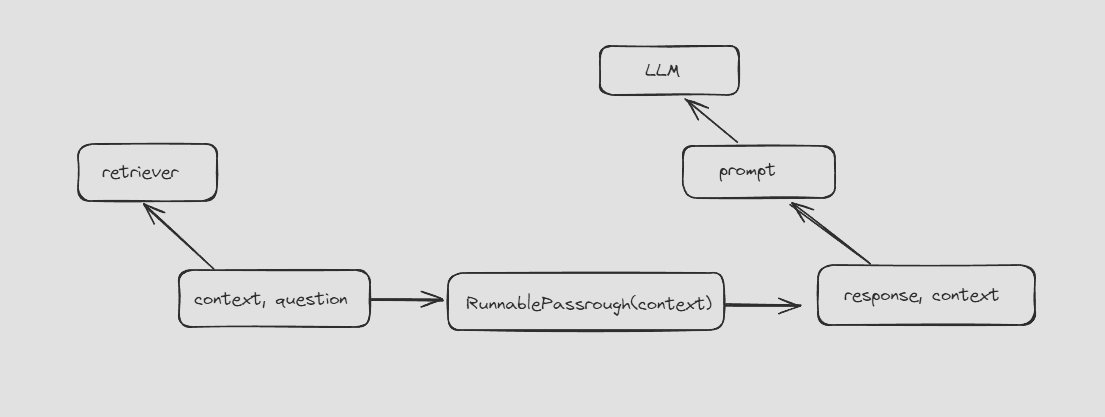


Let's test it out!

In [21]:
question = "Who is the plantiff?"

result = retrieval_augmented_qa_chain.invoke({"question" : question})

print(result["response"].content)

Elon Musk


In [22]:
question = "What does this complaint pertain to?"

result = retrieval_augmented_qa_chain.invoke({"question" : question})

print(result["response"].content)
print(result["context"])

The complaint pertains to breach of fiduciary duty, unfair business practices, and accounting.
[Document(page_content='1 \n2 \n3 \n4 \n5 \n6 \n7 \n8 \n9 \n10 \n11 \n12 \n13 \n14 \n15 \n16 \n17 \n18 \n19 \n20 \n21 \n22 \n23 \n24 \n25 \n26 \n27 \n28 \n \n \n– 31 – \nCOMPLAINT \n \nTHIRD CAUSE OF ACTION \nBreach of Fiduciary Duty  \nAgainst All Defendants \n133. \nPlaintiff realleges and incorporates by reference only paragraphs of this Complaint \nnecessary for his claim of Breach of Fiduciary Duty. \n134. \nUnder California law, Defendants owe fiduciary duties to Plaintiff, including a duty \nto use Plaintiff’s contributions for the purposes for which they were made. E.g., Cal. Bus. & Prof. \nCode § 17510.8. Defendants have repeatedly breached their fiduciary duties to Plaintiff, including \nby:', metadata={'source': 'DataRepository/MuskComplaint.pdf', 'file_path': 'DataRepository/MuskComplaint.pdf', 'page': 30, 'total_pages': 46, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject

We can already see that there are some improvements we could make here.

For now, let's switch gears to RAGAS to see how we can leverage that tool to provide us insight into how our pipeline is performing!

# 🤝 Breakout Room #2

## Task 1: Synthetic Dataset Generation for Evaluation using Ragas

Ragas is a powerful library that lets us evaluate our RAG pipeline by collecting input/output/context triplets and obtaining metrics relating to a number of different aspects of our RAG pipeline.

We'll be evluating on every core metric today, but in order to do that - we'll need to creat a test set. Luckily for us, Ragas can do that directly!

### Synthetic Test Set Generation

We can leverage Ragas' [`Synthetic Test Data generation`](https://docs.ragas.io/en/stable/concepts/testset_generation.html) functionality to generate our own synthetic QC pairs - as well as a synthetic ground truth - quite easily!

> NOTE: This process will use `gpt-3.5-turbo-16k` as the base generator and `gpt-4` as the critic - if you're attempting to create a lot of samples please be aware of cost, as well as rate limits.

In [23]:
eval_documents = documents

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 400
)

eval_documents = text_splitter.split_documents(eval_documents)

eval_documents

[Document(page_content='1 \n2 \n3 \n4 \n5 \n6 \n7 \n8 \n9 \n10 \n11 \n12 \n13 \n14 \n15 \n16 \n17 \n18 \n19 \n20 \n21 \n22 \n23 \n24 \n25 \n26 \n27 \n28 \n \n \nCOMPLAINT \n \nIRELL & MANELLA LLP \nMorgan Chu (SBN 70446) \nAlan Heinrich (SBN 212782) \nIian Jablon (SBN 205458) \nAbigail Sellers (SBN 342380) \nJustin Koo (SBN 351547) \nHenry White (SBN 351549) \n1800 Avenue of the Stars, Suite 900 \nLos Angeles, CA 90067 \nTelephone: (310) 277-1010 \nFax: (310) 203-7199 \nmchu@irell.com \naheinrich@irell.com  \nijablon@irell.com \nasellers@irell.com \njkoo@irell.com \nhwhite@irell.com \n \n \nAttorneys for Plaintiff Elon Musk \nSUPERIOR COURT OF CALIFORNIA \nIN AND FOR THE COUNTY OF SAN FRANCISCO \nELON MUSK, an individual, \nPlaintiff, \nvs.', metadata={'source': 'DataRepository/MuskComplaint.pdf', 'file_path': 'DataRepository/MuskComplaint.pdf', 'page': 0, 'total_pages': 46, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': '', 'c

####❓ Question #2:

Why is it important to split our documents using different parameters when creating our synthetic data?

Answer: it's important to have a great chunking strategy due to reasons like transforming actual query into different queries that are more complex as we will see in question 3 on simple, reasoning and multi_context for creating syntetic data. If we have very small chunks it will make it more difficult to make syntetic data based on multi context.

Also thinking of chunking as a form of hyperparameter is not a bad idea. 

Evol unstruct (wizardlm) paper will further describe a great strategy which RAGAS makes use of!


In [24]:
len(documents)

159

In [25]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context

generator = TestsetGenerator.with_openai()

testset = generator.generate_with_langchain_docs(documents, test_size=10, distributions={simple: 0.25, reasoning: 0.25, multi_context: 0.5})

embedding nodes:   0%|          | 0/318 [00:00<?, ?it/s]

Filename and doc_id are the same for all nodes.


Generating:   0%|          | 0/10 [00:00<?, ?it/s]

####❓ Question #3:

`{simple: 0.5, reasoning: 0.25, multi_context: 0.25}`

What exactly does this mapping refer to?

This mapping refers to how Ragas should focus on when creating the syntetic data - in that particular example
we make 50 % simple, 25 % with reasoning and 25 % with multicontext.

1) simple  - convert simple questions into more complex question
2) reasoning - how it should rewrite questions in a way that answers more effectely through reasoning.
3) multi-context - rewrite questions so it takes multiple related parts of chunks to formulate an answer

> NOTE: Check out the Ragas documentation on this generation process [here](https://docs.ragas.io/en/stable/concepts/testset_generation.html).

Let's look at the output and see what we can learn about it!

In [32]:
testset.test_data[0]

DataRow(question="What were Mr. Musk's concerns about AI that he discussed with Mr. Page?", contexts=['Page, then-CEO of Google’s parent company Alphabet, Inc. Mr. Musk would frequently raise the \ndangers of AI in his conversations with Mr. Page, but to Mr. Musk’s shock, Mr. Page was \nunconcerned. For example, in 2013, Mr. Musk had a passionate exchange with Mr. Page about the \ndangers of AI. He warned that unless safeguards were put in place, “artificial intelligence-systems \nmight replace humans, making our species irrelevant or even extinct.” Mr. Page responded that \nwould merely “be the next stage of evolution,” and claimed Mr. Musk was being a “specist”—that'], ground_truth="Mr. Musk's concerns about AI that he discussed with Mr. Page were that artificial intelligence-systems might replace humans, making our species irrelevant or even extinct.", evolution_type='simple')

### Generating Responses with RAG Pipeline

Now that we have some QC pairs, and some ground truths, let's evaluate our RAG pipeline using Ragas.

The process is, again, quite straightforward - thanks to Ragas and LangChain!

Let's start by extracting our questions and ground truths from our create testset.

We can start by converting our test dataset into a Pandas DataFrame.

In [33]:
test_df = testset.to_pandas()

In [34]:
test_df

,question,contexts,ground_truth,evolution_type,episode_done
0,What were Mr. Musk's concerns about AI that he...,"[Page, then-CEO of Google’s parent company Alp...",Mr. Musk's concerns about AI that he discussed...,simple,True
1,What game did OpenAI compete in using reinforc...,[77. \nInitial work at OpenAI followed much in...,OpenAI competed in Dota 2 using reinforcement ...,simple,True
2,How did Mr. Page respond to Mr. Musk's concern...,"[Page, then-CEO of Google’s parent company Alp...",Mr. Page responded that would merely “be the n...,reasoning,True
3,What are the concerns of US officials regardin...,[chip fabrication plants. If $10 billion from ...,The concerns of US officials regarding investm...,reasoning,True
4,What are the benefits of releasing open versio...,"[challenging.” At the time, OpenAI stated that...",The benefits of releasing open versions of pow...,multi_context,True
5,"""What strategy video game did OpenAI excel in,...",[77. \nInitial work at OpenAI followed much in...,OpenAI excelled in the strategy video game Dot...,multi_context,True
6,"""What was the impact of OpenAI's models on fut...",[1 \n2 \n3 \n4 \n5 \n6 \n7 \n8 \n9 \n10 \n11 \...,Their publication did prove to be useful to th...,multi_context,True
7,What are the US officials' concerns about UAE'...,[chip fabrication plants. If $10 billion from ...,US officials are concerned about UAE's ties to...,multi_context,True
8,What concerns about AGI were raised by Bill Jo...,[18. \nMr. Musk has long recognized that AGI p...,The concerns about AGI raised by Bill Joy and ...,multi_context,True
9,What are some of the models released by OpenAI...,[those connections to the target language. \n7...,OpenAI has released two models: GPT and GPT-2....,simple,True


In [37]:
test_questions = test_df["question"].values.tolist()
test_groundtruths = test_df["ground_truth"].values.tolist()

print(test_questions)
print(test_groundtruths)

["What were Mr. Musk's concerns about AI that he discussed with Mr. Page?", 'What game did OpenAI compete in using reinforcement learning?', "How did Mr. Page respond to Mr. Musk's concerns about AI and what term did he use to describe his viewpoint?", 'What are the concerns of US officials regarding investments in OpenAI, Inc. from the UAE national security advisor, considering UAE\'s ties to China and the "regulatory sandbox" for AI technologies, and why is access to OpenAI\'s conflict-of-interest policy important in this context?', 'What are the benefits of releasing open versions of powerful models, as stated by OpenAI, and how has this approach helped developers of subsequent models?', '"What strategy video game did OpenAI excel in, like DeepMind did in chess, shogi, and Go?"', '"What was the impact of OpenAI\'s models on future model development and how did the communities contribute?"', "What are the US officials' concerns about UAE's ties to China in relation to OpenAI, Inc. an

Now we'll generate responses using our RAG pipeline using the questions we've generated - we'll also need to collect our retrieved contexts for each question.

We'll do this in a simple loop to see exactly what's happening!

In [38]:
answers = []
contexts = []

for question in test_questions:
  response = retrieval_augmented_qa_chain.invoke({"question" : question})
  answers.append(response["response"].content)
  contexts.append([context.page_content for context in response["context"]])

  print(answers)

["Mr. Musk's concerns about AI that he discussed with Mr. Page were related to the dangers of AI potentially replacing humans, making the species irrelevant or even extinct."]
["Mr. Musk's concerns about AI that he discussed with Mr. Page were related to the dangers of AI potentially replacing humans, making the species irrelevant or even extinct.", 'Dota 2']
["Mr. Musk's concerns about AI that he discussed with Mr. Page were related to the dangers of AI potentially replacing humans, making the species irrelevant or even extinct.", 'Dota 2', 'Mr. Page responded to Mr. Musk\'s concerns about AI by saying it would merely be the next stage of evolution. He described Mr. Musk as being a "specist."']
["Mr. Musk's concerns about AI that he discussed with Mr. Page were related to the dangers of AI potentially replacing humans, making the species irrelevant or even extinct.", 'Dota 2', 'Mr. Page responded to Mr. Musk\'s concerns about AI by saying it would merely be the next stage of evolution

Now we can wrap our information in a Hugging Face dataset for use in the Ragas library.

In [39]:
from datasets import Dataset

response_dataset = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

Let's take a peek and see what that looks like!

In [40]:
response_dataset[0]

{'question': "What were Mr. Musk's concerns about AI that he discussed with Mr. Page?",
 'answer': "Mr. Musk's concerns about AI that he discussed with Mr. Page were related to the dangers of AI potentially replacing humans, making the species irrelevant or even extinct.",
 'contexts': ['Page, then-CEO of Google’s parent company Alphabet, Inc. Mr. Musk would frequently raise the \ndangers of AI in his conversations with Mr. Page, but to Mr. Musk’s shock, Mr. Page was \nunconcerned. For example, in 2013, Mr. Musk had a passionate exchange with Mr. Page about the \ndangers of AI. He warned that unless safeguards were put in place, “artificial intelligence-systems \nmight replace humans, making our species irrelevant or even extinct.” Mr. Page responded that \nwould merely “be the next stage of evolution,” and claimed Mr. Musk was being a “specist”—that',
  'advancement of AI presents to society.     \n35. \nFollowing this conversation with Mr. Hassabis, Mr. Musk became increasingly \ncon

## Task 2: Evaluating our Pipeline with Ragas

Now that we have our response dataset - we can finally get into the "meat" of Ragas - evaluation!

First, we'll import the desired metrics, then we can use them to evaluate our created dataset!

Check out the specific metrics we'll be using in the Ragas documentation:

- [Faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html)
- [Answer Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/answer_relevance.html)
- [Context Precision](https://docs.ragas.io/en/stable/concepts/metrics/context_precision.html)
- [Context Recall](https://docs.ragas.io/en/stable/concepts/metrics/context_recall.html)
- [Answer Correctness](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html)

See the accompanied presentation for more in-depth explanations about each of the metrics!

In [41]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
)

metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
]

All that's left to do is call "evaluate" and away we go!

In [42]:
results = evaluate(response_dataset, metrics)

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

In [43]:
results

{'faithfulness': 0.9000, 'answer_relevancy': 0.9634, 'context_recall': 0.9333, 'context_precision': 0.8833, 'answer_correctness': 0.7864}

In [44]:
results_df = results.to_pandas()
results_df

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,What were Mr. Musk's concerns about AI that he...,Mr. Musk's concerns about AI that he discussed...,"[Page, then-CEO of Google’s parent company Alp...",Mr. Musk's concerns about AI that he discussed...,1.0,1.000000,1.000000,1.000000,0.746201
1,What game did OpenAI compete in using reinforc...,Dota 2,[77. \nInitial work at OpenAI followed much in...,OpenAI competed in Dota 2 using reinforcement ...,1.0,0.988049,1.000000,1.000000,0.962706
2,How did Mr. Page respond to Mr. Musk's concern...,Mr. Page responded to Mr. Musk's concerns abou...,"[Page, then-CEO of Google’s parent company Alp...",Mr. Page responded that would merely “be the n...,1.0,0.978955,1.000000,1.000000,0.841048
3,What are the concerns of US officials regardin...,The concerns of US officials regarding investm...,[chip fabrication plants. If $10 billion from ...,The concerns of US officials regarding investm...,1.0,0.960450,1.000000,1.000000,0.849439
4,What are the benefits of releasing open versio...,The benefits of releasing open versions of pow...,"[challenging.” At the time, OpenAI stated that...",The benefits of releasing open versions of pow...,1.0,0.970252,1.000000,1.000000,0.747099
5,"""What strategy video game did OpenAI excel in,...",Dota 2,[a superhuman level of play in the games of ch...,OpenAI excelled in the strategy video game Dot...,0.0,0.888159,1.000000,0.500000,0.968335
6,"""What was the impact of OpenAI's models on fut...",The impact of OpenAI's models on future model ...,"[challenging.” At the time, OpenAI stated that...",Their publication did prove to be useful to th...,1.0,0.942378,1.000000,1.000000,0.839459
7,What are the US officials' concerns about UAE'...,The US officials are concerned about the UAE's...,[chip fabrication plants. If $10 billion from ...,US officials are concerned about UAE's ties to...,1.0,0.970784,1.000000,0.833333,0.618658
8,What concerns about AGI were raised by Bill Jo...,The concerns raised by Bill Joy and echoed by ...,[18. \nMr. Musk has long recognized that AGI p...,The concerns about AGI raised by Bill Joy and ...,1.0,0.959944,1.000000,1.000000,0.844974
9,What are some of the models released by OpenAI...,GPT-2 and GPT-3 were some of the models releas...,"[challenging.” At the time, OpenAI stated that...",OpenAI has released two models: GPT and GPT-2....,1.0,0.975186,0.333333,0.500000,0.446091


## Task 3: Making Adjustments to our RAG Pipeline

Now that we have established a baseline - we can see how any changes impact our pipeline's performance!

Let's modify our retriever and see how that impacts our Ragas metrics!

In [45]:
from langchain.retrievers import MultiQueryRetriever

advanced_retriever = MultiQueryRetriever.from_llm(retriever=retriever, llm=primary_qa_llm)

We'll also re-create our RAG pipeline using the abstractions that come packaged with LangChain v0.1.0!

First, let's create a chain to "stuff" our documents into our context!

In [46]:
from langchain.chains.combine_documents import create_stuff_documents_chain

document_chain = create_stuff_documents_chain(primary_qa_llm, retrieval_qa_prompt)

Next, we'll create the retrieval chain!

In [47]:
from langchain.chains import create_retrieval_chain

retrieval_chain = create_retrieval_chain(advanced_retriever, document_chain)

In [48]:
response = retrieval_chain.invoke({"input": "Who is the plantiff?"})

In [49]:
print(response["answer"])

The plaintiff is Elon Musk.


In [50]:
response = retrieval_chain.invoke({"input": "What does this complaint pertain to?"})

In [51]:
print(response["answer"])

The complaint pertains to a legal case involving Plaintiff Elon Musk alleging breach of fiduciary duty, unfair business practices, and seeking an accounting, restitution, disgorgement of funds, and injunctive relief against all Defendants. The complaint also includes a demand for a jury trial.


Well, just from those responses this chain *feels* better - but lets see how it performs on our eval!

Let's do the same process we did before to collect our pipeline's contexts and answers.

In [52]:
answers = []
contexts = []

for question in test_questions:
  response = retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

Now we can convert this into a dataset, just like we did before.

In [53]:
response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

Let's evaluate on the same metrics we did for the first pipeline and see how it does!

In [54]:
advanced_retrieval_results = evaluate(response_dataset_advanced_retrieval, metrics)

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

In [55]:
advanced_retrieval_results_df = advanced_retrieval_results.to_pandas()
advanced_retrieval_results_df

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,What were Mr. Musk's concerns about AI that he...,Mr. Musk's concerns about AI that he discussed...,"[Page, then-CEO of Google’s parent company Alp...",Mr. Musk's concerns about AI that he discussed...,1.0,1.000000,1.0,0.950000,0.745491
1,What game did OpenAI compete in using reinforc...,"OpenAI competed in Dota 2, a strategy video ga...",[77. \nInitial work at OpenAI followed much in...,OpenAI competed in Dota 2 using reinforcement ...,1.0,1.000000,1.0,1.000000,0.746921
2,How did Mr. Page respond to Mr. Musk's concern...,Mr. Page responded to Mr. Musk's concerns abou...,"[Page, then-CEO of Google’s parent company Alp...",Mr. Page responded that would merely “be the n...,0.5,0.978955,1.0,1.000000,0.833931
3,What are the concerns of US officials regardin...,The concerns of US officials regarding investm...,[chip fabrication plants. If $10 billion from ...,The concerns of US officials regarding investm...,1.0,0.953904,1.0,0.986111,0.808717
4,What are the benefits of releasing open versio...,The benefits of releasing open versions of pow...,"[challenging.” At the time, OpenAI stated that...",The benefits of releasing open versions of pow...,1.0,0.969340,1.0,1.000000,0.808705
5,"""What strategy video game did OpenAI excel in,...","OpenAI excelled in Dota 2, a strategy video ga...",[77. \nInitial work at OpenAI followed much in...,OpenAI excelled in the strategy video game Dot...,1.0,0.907292,1.0,1.000000,0.740220
6,"""What was the impact of OpenAI's models on fut...",OpenAI's models had a significant impact on fu...,"[challenging.” At the time, OpenAI stated that...",Their publication did prove to be useful to th...,1.0,0.939927,1.0,1.000000,0.809080
7,What are the US officials' concerns about UAE'...,The US officials are concerned about the Unite...,[chip fabrication plants. If $10 billion from ...,US officials are concerned about UAE's ties to...,1.0,0.964566,1.0,0.605397,0.647484
8,What concerns about AGI were raised by Bill Jo...,Bill Joy and Elon Musk both raised concerns ab...,[18. \nMr. Musk has long recognized that AGI p...,The concerns about AGI raised by Bill Joy and ...,1.0,0.852408,1.0,1.000000,0.905113
9,What are some of the models released by OpenAI...,"OpenAI released models such as GPT-2, GPT-3, a...","[challenging.” At the time, OpenAI stated that...",OpenAI has released two models: GPT and GPT-2....,1.0,0.935782,0.0,0.325000,0.778133


## Task 4: Evaluating our Adjusted Pipeline Against Our Baseline

Now we can compare our results and see what directional changes occured!

Let's refresh with our initial metrics.

In [56]:
results

{'faithfulness': 0.9000, 'answer_relevancy': 0.9634, 'context_recall': 0.9333, 'context_precision': 0.8833, 'answer_correctness': 0.7864}

And see how our advanced retrieval modified our chain!

In [57]:
advanced_retrieval_results

{'faithfulness': 0.9500, 'answer_relevancy': 0.9502, 'context_recall': 0.9000, 'context_precision': 0.8867, 'answer_correctness': 0.7824}

In [58]:
import pandas as pd

df_original = pd.DataFrame(list(results.items()), columns=['Metric', 'Baseline'])
df_comparison = pd.DataFrame(list(advanced_retrieval_results.items()), columns=['Metric', 'MultiQueryRetriever with Document Stuffing'])

df_merged = pd.merge(df_original, df_comparison, on='Metric')

df_merged['Delta'] = df_merged['MultiQueryRetriever with Document Stuffing'] - df_merged['Baseline']

df_merged

,Metric,Baseline,MultiQueryRetriever with Document Stuffing,Delta
0,faithfulness,0.900000,0.950000,0.050000
1,answer_relevancy,0.963416,0.950217,-0.013198
2,context_recall,0.933333,0.900000,-0.033333
3,context_precision,0.883333,0.886651,0.003317
4,answer_correctness,0.786401,0.782379,-0.004022


## Task 5: Testing OpenAI's Claim

Now that we've seen how our retriever can impact the performance of our RAG pipeline - let's see how changing our embedding model impacts performance.

####🏗️ Activity #2:

Please provide markdown, or code comments, to explain which each of the following steps are doing!

new_embedding contains an instance of OpenAIEmbeddings class that uses text-embedding-3-small embedding model with a dimension of 512

In [59]:
new_embeddings = OpenAIEmbeddings(model="text-embedding-3-small",dimensions=512)

next part creates a faiss vector store from our documents that are embedded with text-embedding-3-small embedding model and assigns it to vector_store variable

In [60]:
vector_store = FAISS.from_documents(documents, new_embeddings)

next part gets back a retriever from the faiss vector store

In [61]:
new_retriever = vector_store.as_retriever()

next steps makes it able to write a set of queries. We can reetrieve docs for each query.

In [62]:
new_advanced_retriever = MultiQueryRetriever.from_llm(retriever=new_retriever, llm=primary_qa_llm)

This create a retrieval chain that retrieves documens and them passes them on.

In [63]:
new_retrieval_chain = create_retrieval_chain(new_advanced_retriever, document_chain)

Next part goes through each test question and get a response back from the faiss retriever. It then appends answer part to the answers array. 

In [64]:
answers = []
contexts = []

for question in test_questions:
  response = new_retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

This next part makes a new dictionary out of the test questions, answer, context and test groundtrouths that we have made so far.

In [65]:
new_response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

Then the next part evaluates on the dictionary we just made on the metrics    faithfulness, answer_relevancy, context_recall, context_precision,
answer_correctness.

In [66]:
new_advanced_retrieval_results = evaluate(new_response_dataset_advanced_retrieval, metrics)

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

What then comes back with is how well result is based on these metrics

In [67]:
new_advanced_retrieval_results

{'faithfulness': 0.8611, 'answer_relevancy': 0.9563, 'context_recall': 1.0000, 'context_precision': 0.8738, 'answer_correctness': 0.7359}

Now we can compare baseline with ada and text embedding 3 model just to see how well they are doing

In [68]:
df_baseline = pd.DataFrame(list(results.items()), columns=['Metric', 'Baseline'])
df_original = pd.DataFrame(list(advanced_retrieval_results.items()), columns=['Metric', 'ADA'])
df_comparison = pd.DataFrame(list(new_advanced_retrieval_results.items()), columns=['Metric', 'Text Embedding 3'])

df_merged = pd.merge(df_original, df_comparison, on='Metric')
df_merged = pd.merge(df_baseline, df_merged, on="Metric")

df_merged['Delta - TE3 -> ADA'] = df_merged['Text Embedding 3'] - df_merged['ADA']
df_merged['Delta - TE3 -> Baseline'] = df_merged['Text Embedding 3'] - df_merged['Baseline']

df_merged

,Metric,Baseline,ADA,Text Embedding 3,Delta - TE3 -> ADA,Delta - TE3 -> Baseline
0,faithfulness,0.900000,0.950000,0.861111,-0.088889,-0.038889
1,answer_relevancy,0.963416,0.950217,0.956333,0.006116,-0.007082
2,context_recall,0.933333,0.900000,1.000000,0.100000,0.066667
3,context_precision,0.883333,0.886651,0.873849,-0.012802,-0.009484
4,answer_correctness,0.786401,0.782379,0.735923,-0.046456,-0.050478


####❓ Question #4:

Do you think, in your opinion, `text-embedding-3-small` is significantly better than `ada`?

answer: if we break it down this compairison on the following, then overall it provides a bit better at some of the parameters, but not all and is not significantly better than `ada`

faithfullness - if we look at the delta text embedding 3 is a bit worse than ada by 0.08

answer_relevancy - text embedding 3 better on answer relevance by 0.0061

context recall -  text embedding 3 does quiet good in context recall with 0.10 than ADA

context precision - text embedding 3 a bit worse on context precision with -0.012

answer correctness - text embedding 3 a bit worse than ADA with -0.04


## BONUS ACTIVITY: Showcase Multi-Context Performance Changes

Now that we've looked at a number of different examples - showcase the difference on the multi-context *specific* questions that were synthetically generated.

> NOTE: You have all the data you'll need already in the notebook if you made it to this step!

In [75]:
### YOUR CODE HERE
test_df
test_df.loc[test_df['evolution_type'] == 'multi_context']

,question,contexts,ground_truth,evolution_type,episode_done
4,What are the benefits of releasing open versio...,"[challenging.” At the time, OpenAI stated that...",The benefits of releasing open versions of pow...,multi_context,True
5,"""What strategy video game did OpenAI excel in,...",[77. \nInitial work at OpenAI followed much in...,OpenAI excelled in the strategy video game Dot...,multi_context,True
6,"""What was the impact of OpenAI's models on fut...",[1 \n2 \n3 \n4 \n5 \n6 \n7 \n8 \n9 \n10 \n11 \...,Their publication did prove to be useful to th...,multi_context,True
7,What are the US officials' concerns about UAE'...,[chip fabrication plants. If $10 billion from ...,US officials are concerned about UAE's ties to...,multi_context,True
8,What concerns about AGI were raised by Bill Jo...,[18. \nMr. Musk has long recognized that AGI p...,The concerns about AGI raised by Bill Joy and ...,multi_context,True
